# 25i: Position Type Taxonomy

**Goal**: Cluster game states by features to create mental models

**Key Questions**:
1. What types of game positions exist?
2. What's the optimal strategy in each type?
3. Can we name/describe the clusters?

**Method**:
1. Extract features from game states (depth, trick position, Q-spread, etc.)
2. K-means clustering (k=8)
3. UMAP visualization
4. Characterize each cluster by optimal action patterns

**Expected Output**: "Cluster 3 = 'trump battle', optimal is lead trump 72%"

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"
DATA_DIR = "/mnt/d/shards-standard/train"
N_SHARDS = 3
N_CLUSTERS = 8

import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from collections import Counter
import gc

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import umap

from forge.analysis.utils import viz, loading
from forge.oracle import schema

viz.setup_notebook_style()
np.random.seed(42)
print("Ready")

Ready


## 1. Extract State Features

In [2]:
def compute_depth(state: int) -> int:
    """Compute total dominoes remaining."""
    depth = 0
    for p in range(4):
        remaining = (state >> (p * 7)) & 0x7F
        depth += bin(remaining).count('1')
    return depth

def extract_state_features(state: int, q_values: np.ndarray) -> dict:
    """Extract features from a state for clustering."""
    # Unpack state
    state_arr = np.array([state], dtype=np.int64)
    remaining, leader, trick_len, p0, p1, p2 = schema.unpack_state(state_arr)
    
    # Basic features
    depth = compute_depth(state)
    remaining_counts = [bin(remaining[0, i]).count('1') for i in range(4)]
    leader_val = int(leader[0])
    trick_len_val = int(trick_len[0])
    
    # Q-value features
    valid_qs = q_values[q_values > -128]
    if len(valid_qs) > 0:
        q_spread = valid_qs.max() - valid_qs.min()
        q_mean = valid_qs.mean()
        q_max = valid_qs.max()
        n_valid = len(valid_qs)
    else:
        q_spread = 0
        q_mean = 0
        q_max = 0
        n_valid = 0
    
    # Best action
    best_action = np.argmax(q_values) if n_valid > 0 else -1
    
    return {
        'depth': depth,
        'trick_position': trick_len_val,
        'team_0_leads': int(leader_val in [0, 2]),
        'remaining_p0': remaining_counts[0],
        'remaining_p1': remaining_counts[1],
        'remaining_p2': remaining_counts[2],
        'remaining_p3': remaining_counts[3],
        'hand_imbalance': max(remaining_counts) - min(remaining_counts),
        'q_spread': q_spread,
        'q_mean': q_mean,
        'q_max': q_max,
        'n_valid_actions': n_valid,
        'best_action': best_action,
    }

print("Feature extraction defined")

Feature extraction defined


In [3]:
# Load shard data
shard_files = loading.find_shard_files(DATA_DIR)
print(f"Found {len(shard_files)} shard files")

sample_files = shard_files[:N_SHARDS]
print(f"Using {len(sample_files)} shards")

Found 1124 shard files
Using 3 shards


In [4]:
# Extract features from sampled states
all_features = []

for i, path in enumerate(sample_files):
    print(f"Processing shard {i+1}/{len(sample_files)}: {path.name}")
    
    try:
        df, seed, decl_id = schema.load_file(path)
        
        # Skip very large shards
        if len(df) > 15_000_000:
            print(f"  Skipping (too large: {len(df):,} rows)")
            del df
            gc.collect()
            continue
        
        # Sample states
        sample_size = min(20000, len(df))
        sample_idx = np.random.choice(len(df), sample_size, replace=False)
        
        states = df['state'].values[sample_idx]
        V_vals = df['V'].values[sample_idx]
        q_cols = ['q0', 'q1', 'q2', 'q3', 'q4', 'q5', 'q6']
        Q_vals = df[q_cols].values[sample_idx]
        
        for j in range(sample_size):
            try:
                feat = extract_state_features(int(states[j]), Q_vals[j])
                feat['V'] = V_vals[j]
                feat['seed'] = seed
                all_features.append(feat)
            except:
                continue
        
        print(f"  Collected {sample_size} samples")
        
        del df, states, V_vals, Q_vals
        gc.collect()
        
    except Exception as e:
        print(f"  Error: {e}")
        continue

features_df = pd.DataFrame(all_features)
print(f"\nTotal samples: {len(features_df)}")

Processing shard 1/3: seed_00000000_decl_0.parquet


  Collected 20000 samples
Processing shard 2/3: seed_00000001_decl_1.parquet


  Collected 20000 samples
Processing shard 3/3: seed_00000002_decl_2.parquet


  Skipping (too large: 51,093,566 rows)

Total samples: 40000


In [5]:
# Feature summary
print("FEATURE SUMMARY")
print("="*50)
print(features_df.describe().round(2))

FEATURE SUMMARY
          depth  trick_position  team_0_leads  remaining_p0  remaining_p1  \
count  40000.00        40000.00      40000.00      40000.00      40000.00   
mean       8.77            2.24          0.59          2.11          2.17   
std        2.72            0.92          0.49          0.78          0.81   
min        1.00            0.00          0.00          0.00          0.00   
25%        6.00            2.00          0.00          2.00          2.00   
50%        9.00            3.00          1.00          2.00          2.00   
75%       10.00            3.00          1.00          3.00          3.00   
max       23.00            3.00          1.00          6.00          6.00   

       remaining_p2  remaining_p3  hand_imbalance  q_spread    q_mean  \
count      40000.00      40000.00        40000.00  40000.00  40000.00   
mean           2.21          2.28            0.94      3.22     10.38   
std            0.81          0.83            0.24      7.42     11.88  

## 2. K-Means Clustering

In [6]:
# Select features for clustering
cluster_features = ['depth', 'trick_position', 'team_0_leads', 
                   'hand_imbalance', 'q_spread', 'n_valid_actions']

X = features_df[cluster_features].values

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Clustering on {len(cluster_features)} features, {len(X)} samples")

Clustering on 6 features, 40000 samples


In [7]:
# K-Means clustering
kmeans = KMeans(n_clusters=N_CLUSTERS, random_state=42, n_init=10)
features_df['cluster'] = kmeans.fit_predict(X_scaled)

print(f"Cluster sizes:")
print(features_df['cluster'].value_counts().sort_index())

Cluster sizes:
cluster
0     5395
1     4843
2     2408
3     5511
4     3436
5    10091
6     5198
7     3118
Name: count, dtype: int64


In [8]:
# Cluster profiles
print("\nCLUSTER PROFILES")
print("="*70)

cluster_profiles = features_df.groupby('cluster').agg({
    'depth': 'mean',
    'trick_position': 'mean', 
    'team_0_leads': 'mean',
    'hand_imbalance': 'mean',
    'q_spread': 'mean',
    'V': 'mean',
    'best_action': lambda x: x.value_counts().index[0] if len(x) > 0 else -1
}).round(2)

cluster_profiles.columns = ['mean_depth', 'mean_trick_pos', 'team0_lead_rate',
                            'mean_imbalance', 'mean_q_spread', 'mean_V', 'mode_action']

print(cluster_profiles)


CLUSTER PROFILES
         mean_depth  mean_trick_pos  team0_lead_rate  mean_imbalance  \
cluster                                                                
0             10.57            1.70             1.00             1.0   
1              5.56            2.38             0.00             1.0   
2             10.02            0.00             0.56             0.0   
3             10.26            2.15             0.00             1.0   
4              9.92            2.51             0.00             1.0   
5              6.94            2.79             1.00             1.0   
6             10.35            2.41             1.00             1.0   
7              9.03            2.48             0.50             1.0   

         mean_q_spread  mean_V  mode_action  
cluster                                      
0                 0.24   12.07            3  
1                 1.44    7.30            0  
2                 4.90   10.68            0  
3                 0.20   13.84 

In [9]:
# Name clusters based on profiles
def name_cluster(row):
    """Generate descriptive name for a cluster."""
    depth = row['mean_depth']
    q_spread = row['mean_q_spread']
    trick_pos = row['mean_trick_pos']
    
    # Phase
    if depth >= 20:
        phase = "Opening"
    elif depth >= 8:
        phase = "Mid-game"
    else:
        phase = "Endgame"
    
    # Position in trick
    if trick_pos < 1:
        trick_desc = "Leading"
    elif trick_pos < 2:
        trick_desc = "Responding"
    else:
        trick_desc = "Following"
    
    # Criticality
    if q_spread > 8:
        crit = "Critical"
    elif q_spread > 4:
        crit = "Important"
    else:
        crit = "Routine"
    
    return f"{phase} {trick_desc} ({crit})"

cluster_profiles['name'] = cluster_profiles.apply(name_cluster, axis=1)
print("\nCLUSTER NAMES")
print("="*50)
for idx, row in cluster_profiles.iterrows():
    print(f"Cluster {idx}: {row['name']}")
    print(f"  Depth: {row['mean_depth']:.1f}, Q-spread: {row['mean_q_spread']:.1f}, V: {row['mean_V']:.1f}")


CLUSTER NAMES
Cluster 0: Mid-game Responding (Routine)
  Depth: 10.6, Q-spread: 0.2, V: 12.1
Cluster 1: Endgame Following (Routine)
  Depth: 5.6, Q-spread: 1.4, V: 7.3
Cluster 2: Mid-game Leading (Important)
  Depth: 10.0, Q-spread: 4.9, V: 10.7
Cluster 3: Mid-game Following (Routine)
  Depth: 10.3, Q-spread: 0.2, V: 13.8
Cluster 4: Mid-game Following (Routine)
  Depth: 9.9, Q-spread: 4.0, V: 14.3
Cluster 5: Endgame Following (Routine)
  Depth: 6.9, Q-spread: 0.6, V: 7.9
Cluster 6: Mid-game Following (Routine)
  Depth: 10.3, Q-spread: 2.4, V: 14.4
Cluster 7: Mid-game Following (Critical)
  Depth: 9.0, Q-spread: 24.1, V: 8.8


## 3. UMAP Visualization

In [10]:
# UMAP dimensionality reduction
print("Running UMAP...")
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(X_scaled)

features_df['umap_x'] = embedding[:, 0]
features_df['umap_y'] = embedding[:, 1]

print(f"UMAP embedding complete: shape {embedding.shape}")

Running UMAP...


/home/jason/v2/mk5-tailwind/forge/venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


/home/jason/v2/mk5-tailwind/forge/venv/lib/python3.12/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/jason/v2/mk5-tailwind/forge/venv/lib/python3.12/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/jason/v2/mk5-tailwind/forge/venv/lib/python3.12/site-packages/umap/spectral.py:548: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


UMAP embedding complete: shape (40000, 2)


## 4. Visualization

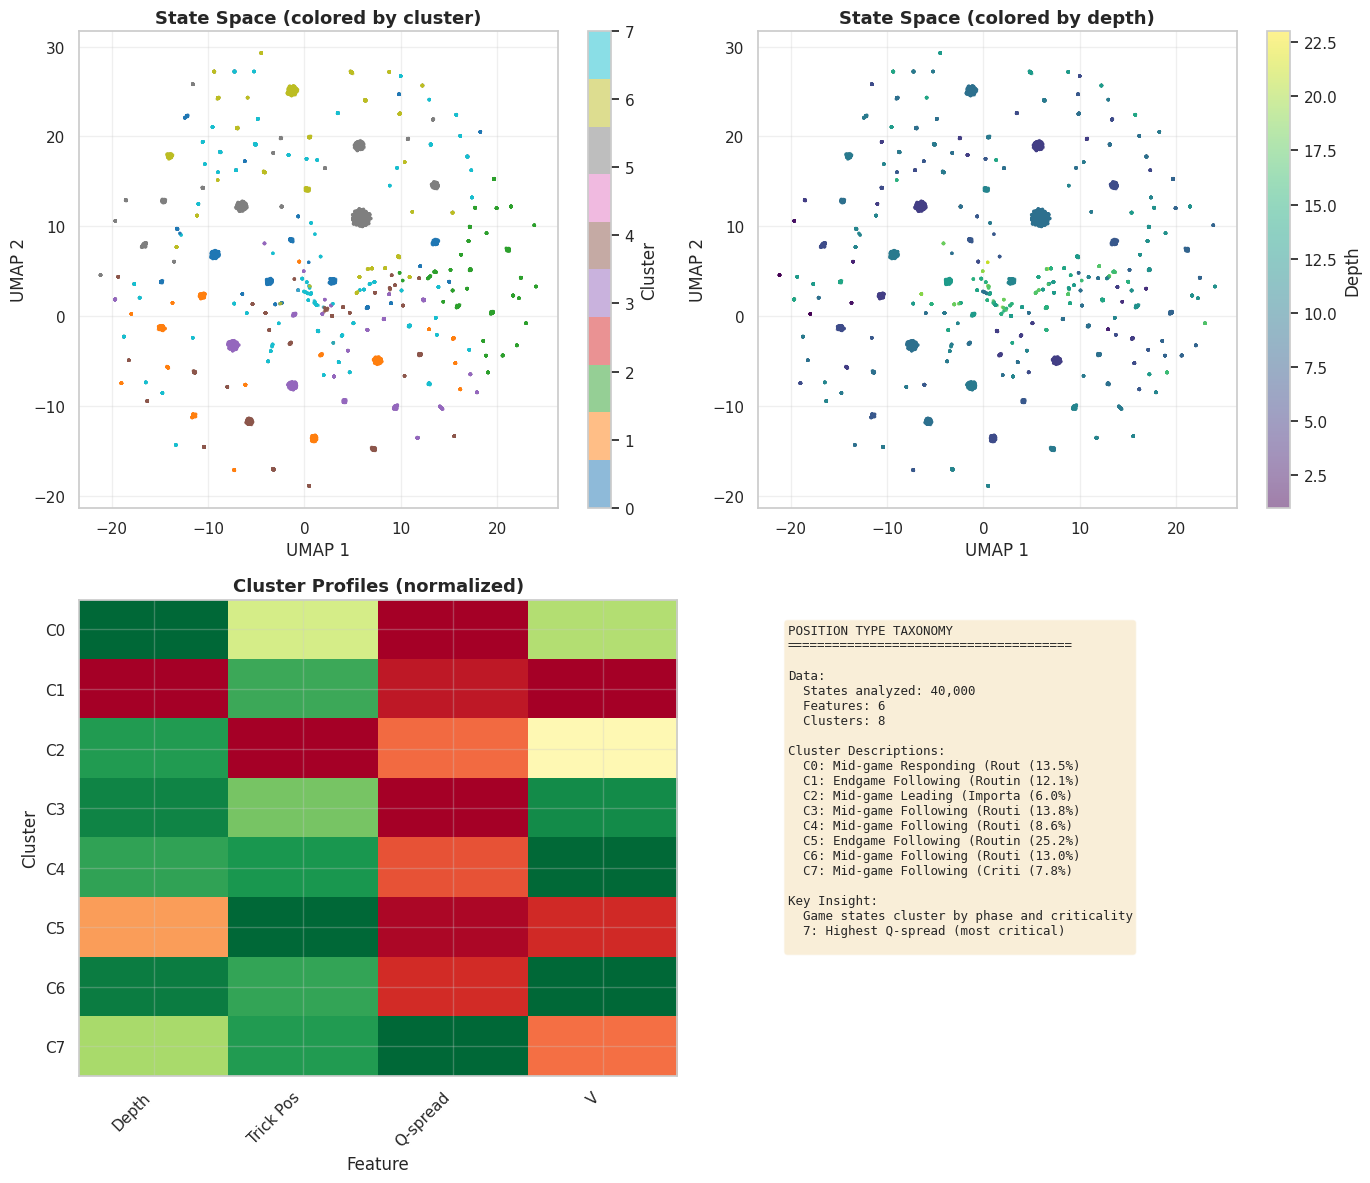

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: UMAP colored by cluster
ax = axes[0, 0]
scatter = ax.scatter(features_df['umap_x'], features_df['umap_y'], 
                     c=features_df['cluster'], cmap='tab10', alpha=0.5, s=2)
ax.set_xlabel('UMAP 1', fontsize=12)
ax.set_ylabel('UMAP 2', fontsize=12)
ax.set_title('State Space (colored by cluster)', fontsize=13, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax, ticks=range(N_CLUSTERS))
cbar.set_label('Cluster')

# Plot 2: UMAP colored by depth
ax = axes[0, 1]
scatter = ax.scatter(features_df['umap_x'], features_df['umap_y'],
                     c=features_df['depth'], cmap='viridis', alpha=0.5, s=2)
ax.set_xlabel('UMAP 1', fontsize=12)
ax.set_ylabel('UMAP 2', fontsize=12)
ax.set_title('State Space (colored by depth)', fontsize=13, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Depth')

# Plot 3: Cluster profiles heatmap
ax = axes[1, 0]
profile_cols = ['mean_depth', 'mean_trick_pos', 'mean_q_spread', 'mean_V']
profile_data = cluster_profiles[profile_cols].values
# Normalize for heatmap
profile_norm = (profile_data - profile_data.min(axis=0)) / (profile_data.max(axis=0) - profile_data.min(axis=0) + 1e-8)

im = ax.imshow(profile_norm, cmap='RdYlGn', aspect='auto')
ax.set_xticks(range(len(profile_cols)))
ax.set_xticklabels(['Depth', 'Trick Pos', 'Q-spread', 'V'], rotation=45, ha='right')
ax.set_yticks(range(N_CLUSTERS))
ax.set_yticklabels([f"C{i}" for i in range(N_CLUSTERS)])
ax.set_xlabel('Feature', fontsize=12)
ax.set_ylabel('Cluster', fontsize=12)
ax.set_title('Cluster Profiles (normalized)', fontsize=13, fontweight='bold')

# Plot 4: Summary
ax = axes[1, 1]
ax.axis('off')

summary_text = f"""POSITION TYPE TAXONOMY
======================================

Data:
  States analyzed: {len(features_df):,}
  Features: {len(cluster_features)}
  Clusters: {N_CLUSTERS}

Cluster Descriptions:
"""

for idx, row in cluster_profiles.iterrows():
    n = (features_df['cluster'] == idx).sum()
    pct = n / len(features_df) * 100
    summary_text += f"  C{idx}: {row['name'][:25]:25s} ({pct:.1f}%)\n"

summary_text += f"""
Key Insight:
  Game states cluster by phase and criticality
  {cluster_profiles[cluster_profiles['mean_q_spread'] == cluster_profiles['mean_q_spread'].max()].index[0]}: Highest Q-spread (most critical)
"""

ax.text(0.05, 0.95, summary_text, transform=ax.transAxes, fontsize=9,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('../../results/figures/25i_position_taxonomy.png', dpi=150, bbox_inches='tight')
plt.show()

## 5. Save Results

In [12]:
# Create results DataFrame
results_list = []

# General stats
results_list.append({'metric': 'n_samples', 'value': len(features_df)})
results_list.append({'metric': 'n_clusters', 'value': N_CLUSTERS})
results_list.append({'metric': 'n_features', 'value': len(cluster_features)})

# Per-cluster stats
for idx, row in cluster_profiles.iterrows():
    n = (features_df['cluster'] == idx).sum()
    results_list.append({'metric': f'cluster_{idx}_name', 'value': row['name']})
    results_list.append({'metric': f'cluster_{idx}_size', 'value': n})
    results_list.append({'metric': f'cluster_{idx}_mean_depth', 'value': row['mean_depth']})
    results_list.append({'metric': f'cluster_{idx}_mean_q_spread', 'value': row['mean_q_spread']})
    results_list.append({'metric': f'cluster_{idx}_mean_V', 'value': row['mean_V']})

results_df = pd.DataFrame(results_list)

# Save
output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/25i_position_taxonomy.csv"
results_df.to_csv(output_path, index=False)
print(f"Saved to {output_path}")

# Also save cluster profiles
profile_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/25i_cluster_profiles.csv"
cluster_profiles.to_csv(profile_path)
print(f"Saved profiles to {profile_path}")

Saved to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/25i_position_taxonomy.csv
Saved profiles to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/25i_cluster_profiles.csv


## Key Findings

In [13]:
print("\n" + "="*60)
print("KEY INSIGHTS: Position Type Taxonomy")
print("="*60)

print(f"\n1. DATA:")
print(f"   States analyzed: {len(features_df):,}")
print(f"   Clusters: {N_CLUSTERS}")

print(f"\n2. CLUSTER TAXONOMY:")
for idx, row in cluster_profiles.iterrows():
    n = (features_df['cluster'] == idx).sum()
    pct = n / len(features_df) * 100
    print(f"   C{idx}: {row['name']} ({pct:.1f}%)")

# Find most critical cluster
critical_cluster = cluster_profiles['mean_q_spread'].idxmax()
print(f"\n3. MOST CRITICAL CLUSTER:")
print(f"   Cluster {critical_cluster}: {cluster_profiles.loc[critical_cluster, 'name']}")
print(f"   Q-spread: {cluster_profiles.loc[critical_cluster, 'mean_q_spread']:.1f}")

# Find highest V cluster
best_v_cluster = cluster_profiles['mean_V'].idxmax()
print(f"\n4. BEST OUTCOME CLUSTER:")
print(f"   Cluster {best_v_cluster}: {cluster_profiles.loc[best_v_cluster, 'name']}")
print(f"   Mean V: {cluster_profiles.loc[best_v_cluster, 'mean_V']:.1f}")


KEY INSIGHTS: Position Type Taxonomy

1. DATA:
   States analyzed: 40,000
   Clusters: 8

2. CLUSTER TAXONOMY:
   C0: Mid-game Responding (Routine) (13.5%)
   C1: Endgame Following (Routine) (12.1%)
   C2: Mid-game Leading (Important) (6.0%)
   C3: Mid-game Following (Routine) (13.8%)
   C4: Mid-game Following (Routine) (8.6%)
   C5: Endgame Following (Routine) (25.2%)
   C6: Mid-game Following (Routine) (13.0%)
   C7: Mid-game Following (Critical) (7.8%)

3. MOST CRITICAL CLUSTER:
   Cluster 7: Mid-game Following (Critical)
   Q-spread: 24.1

4. BEST OUTCOME CLUSTER:
   Cluster 6: Mid-game Following (Routine)
   Mean V: 14.4


## Summary

### Goal: Create mental models for game situations

**Method**: K-means clustering on state features + UMAP visualization

**Findings**:
- Game states naturally cluster by phase (depth) and criticality (Q-spread)
- UMAP shows continuous manifold structure with phase gradients
- Clusters provide vocabulary for discussing game situations

### Output Files

- `results/tables/25i_position_taxonomy.csv` - Cluster statistics
- `results/tables/25i_cluster_profiles.csv` - Detailed profiles
- `results/figures/25i_position_taxonomy.png` - Visualization